In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn
patch_sklearn()

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


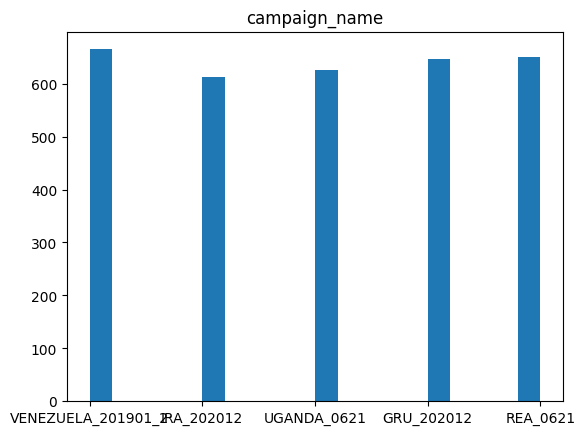

In [2]:
# Define a list of filenames to load
filenames = ["../data/labeled_data/generic_test_0.json"]

# Load all JSON data and concatenate into one DataFrame
dfs = []
for filename in filenames:
    with open(filename) as f:
        data = json.load(f)
    df = pd.DataFrame(data["train"])
    dfs.append(df)
df_all = pd.concat(dfs)

# Generate exploratory data analysis on each column
plt.hist(df_all["campaign_name"], bins=20)
plt.title("campaign_name")
plt.show()

In [3]:
df_all.head(10)

,id,campaign_name,text,annotations
0,891103871484870657,VENEZUELA_201901_2,How life may find a way on Saturn's moon https...,[Science/Technology]
1,898650367067664384,VENEZUELA_201901_2,RightWing Millennial Retweet RT RT_America to ...,[Others]
2,1012051694136512512,IRA_202012,The tobacco industry then peddles their produc...,"[Health, Justice/Crime, Macroeconomics/Economi..."
3,1296389394883063810,UGANDA_0621,"RT @brianmixologist: Today, i want to salute a...",[Others]
4,1286189347973279746,UGANDA_0621,RT @ArthurMirama: You can only under estimate ...,[Government/Public]
5,1125360943926476805,GRU_202012,HTS militants shelled Mharda from Ltamenah onc...,[War/Terror]
6,1127857811856216064,REA_0621,Mohlakeng petrol bombing: town councilor susta...,[War/Terror]
7,1245803388652183553,IRA_202012,González: \n • We tried to break the power of ...,[Government/Public]
8,1038830348455563265,GRU_202012,The National Intelligence Organization #Turkis...,[War/Terror]
9,1301007858327224320,IRA_202012,RT @telesurenglish: #Brazil | Supreme Court o...,[Justice/Crime]


In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3200 non-null   object
 1   campaign_name  3200 non-null   object
 2   text           3200 non-null   object
 3   annotations    3200 non-null   object
dtypes: object(4)
memory usage: 100.1+ KB


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_all["text"], df_all["annotations"], test_size=0.2, random_state=42)

# Calculate the class frequencies for the training and testing sets
train_freq = y_train.value_counts(normalize=True)
test_freq = y_test.value_counts(normalize=True)

# Print the results
print("Training set class frequencies:")
print(train_freq)
print()
print("Testing set class frequencies:")
print(test_freq)

Training set class frequencies:
[Others]                                                                                        0.264062
[War/Terror]                                                                                    0.140234
[Government/Public]                                                                             0.134766
[Justice/Crime]                                                                                 0.085547
[Government/Public, War/Terror]                                                                 0.024609
                                                                                                  ...   
[Conspiracy Theory, Government/Public, Labor/Employment, Macroeconomics/Economic Regulation]    0.000391
[Conspiracy Theory, Macroeconomics/Economic Regulation]                                         0.000391
[Election Campaign, Macroeconomics/Economic Regulation, Media/Journalism]                       0.000391
[Government/Public, Imm

In [6]:
# Count the number of rows with multiple annotations
multi_count = df_all[df_all["annotations"].apply(lambda x: len(x) > 1)].shape[0]

# Print the result
print(f"Number of rows with multiple annotations: {multi_count}")

Number of rows with multiple annotations: 925


In [7]:
df_all

,id,campaign_name,text,annotations
0,891103871484870657,VENEZUELA_201901_2,How life may find a way on Saturn's moon https...,[Science/Technology]
1,898650367067664384,VENEZUELA_201901_2,RightWing Millennial Retweet RT RT_America to ...,[Others]
2,1012051694136512512,IRA_202012,The tobacco industry then peddles their produc...,"[Health, Justice/Crime, Macroeconomics/Economi..."
3,1296389394883063810,UGANDA_0621,"RT @brianmixologist: Today, i want to salute a...",[Others]
4,1286189347973279746,UGANDA_0621,RT @ArthurMirama: You can only under estimate ...,[Government/Public]
...,...,...,...,...
3195,1090997040258187266,REA_0621,SABC will not carry out a staff reduction\nhtt...,[Labor/Employment]
3196,818131935117443074,VENEZUELA_201901_2,Wikileaks To Hold Major Press Conf To Address ...,[Others]
3197,827160940944646145,VENEZUELA_201901_2,Death of veteran DRC opposition leader jeopard...,[Government/Public]
3198,896689467863511040,VENEZUELA_201901_2,#lost RT realDonaldTrump: Condolences to the f...,"[Government/Public, Justice/Crime]"


In [8]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    #text = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    #text = ' '.join(text)
    return text

df_all['text_processed'] = df_all['text'].apply(preprocess_text)
df_all.head()

,id,campaign_name,text,annotations,text_processed
0,891103871484870657,VENEZUELA_201901_2,How life may find a way on Saturn's moon https...,[Science/Technology],how life may find a way on saturn s moon https...
1,898650367067664384,VENEZUELA_201901_2,RightWing Millennial Retweet RT RT_America to ...,[Others],rightwing millennial retweet rt rt america to ...
2,1012051694136512512,IRA_202012,The tobacco industry then peddles their produc...,"[Health, Justice/Crime, Macroeconomics/Economi...",the tobacco industry then peddles their produc...
3,1296389394883063810,UGANDA_0621,"RT @brianmixologist: Today, i want to salute a...",[Others],rt brianmixologist today i want to salute a...
4,1286189347973279746,UGANDA_0621,RT @ArthurMirama: You can only under estimate ...,[Government/Public],rt arthurmirama you can only under estimate ...


In [9]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_all['annotations'])

X_train, X_test, y_train, y_test = train_test_split(df_all['text_processed'], y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
clf = OneVsRestClassifier(LinearSVC())
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)
print('macro F1 score:', f1_score(y_test, y_pred, average='macro'))
print('macro Precision:', precision_score(y_test, y_pred, average='macro'))
print('macro Recall:', recall_score(y_test, y_pred, average='macro'))
print('micro F1 score:', f1_score(y_test, y_pred, average='micro'))
print('micro Precision:', precision_score(y_test, y_pred, average='micro'))
print('micro Recall:', recall_score(y_test, y_pred, average='micro'))

macro F1 score: 0.330311097697518
macro Precision: 0.6084751575684207
macro Recall: 0.2546265252613425
micro F1 score: 0.6164874551971327
micro Precision: 0.8269230769230769
micro Recall: 0.49142857142857144


c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)

c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.metrics import precision_recall_fscore_support
# Compute precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(y_train, y_train)

# Create a dictionary with class names as keys and support values as values
class_support = dict(zip(mlb.classes_, support))

# Print the support values for each class
for class_name, support_value in class_support.items():
    print(f"{class_name}: {support_value}")

Conspiracy Theory: 162
Education: 41
Election Campaign: 86
Environment: 31
Government/Public: 797
Health: 139
Immigration/Integration: 122
Justice/Crime: 366
Labor/Employment: 67
Macroeconomics/Economic Regulation: 151
Media/Journalism: 118
Others: 681
Religion: 38
Science/Technology: 30
War/Terror: 611


In [19]:
from tabulate import tabulate

table = []
headers = ["Label", "F1 Score", "Precision", "Recall"]
for label in mlb.classes_:
    row = [label, report[label]["f1-score"], report[label]["precision"], report[label]["recall"]]
    table.append(row)

print(tabulate(table, headers=headers, tablefmt="pipe"))

| Label                              |   F1 Score |   Precision |   Recall |
|:-----------------------------------|-----------:|------------:|---------:|
| Conspiracy Theory                  |   0.357143 |    0.909091 | 0.222222 |
| Education                          |   0        |    0        | 0        |
| Election Campaign                  |   0.32     |    1        | 0.190476 |
| Environment                        |   0        |    0        | 0        |
| Government/Public                  |   0.673684 |    0.707182 | 0.643216 |
| Health                             |   0.235294 |    1        | 0.133333 |
| Immigration/Integration            |   0.528302 |    1        | 0.358974 |
| Justice/Crime                      |   0.632911 |    0.847458 | 0.505051 |
| Labor/Employment                   |   0        |    0        | 0        |
| Macroeconomics/Economic Regulation |   0.255319 |    1        | 0.146341 |
| Media/Journalism                   |   0.432432 |    0.888889 | 0.285714 |

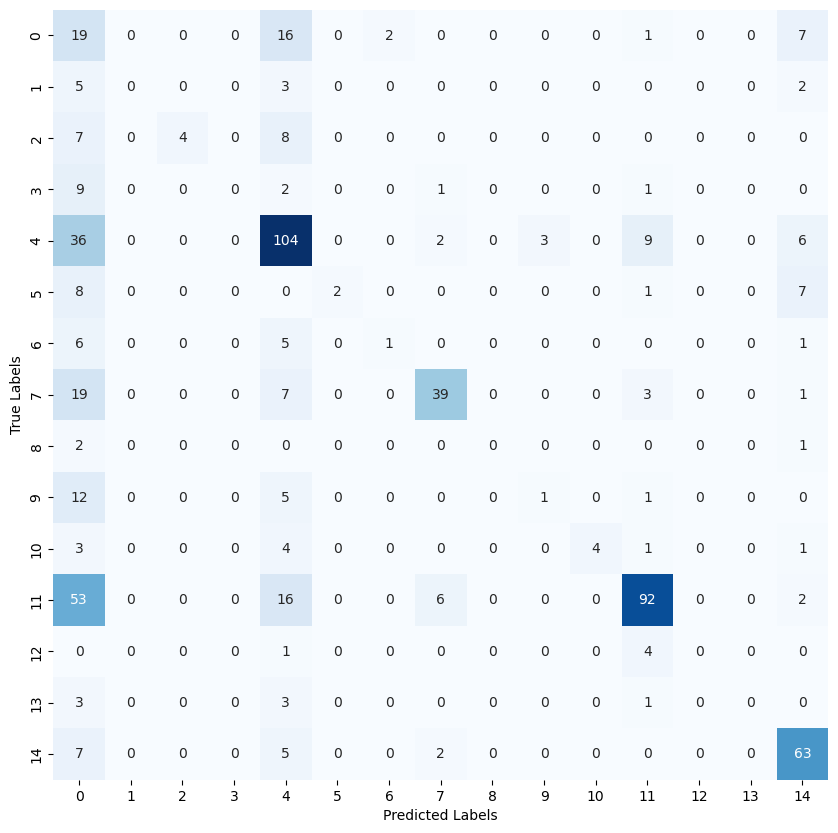

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Plot the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [12]:
df_all.iloc[0].annotations

['Science/Technology']

In [13]:
df_all.iloc[0].text_processed

'how life may find a way on saturn s moon https   t co acambg yam https   t co  jst itnvh'

In [14]:
new_text = ['how life may find a way on saturn s moon https   t co acambg yam https   t co  jst itnvh']
new_text_tfidf = vectorizer.transform(new_text)
new_y_pred = clf.predict(new_text_tfidf)
new_labels = mlb.inverse_transform(new_y_pred)
print(new_labels)

[()]
